In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
import numpy as np
import datetime as dt

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


### Pull in SNTL Data, basins and closest sntl sites

In [2]:
#EPSG code
co_epsg = 32613
# UCRB Basins
ucrb_hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
ucrb_hcdn_basins = ucrb_hcdn_basins.set_crs(32613,allow_override=True)
bad_gages = ucrb_hcdn_basins.index.isin(['09306242','09378170','09378630']) 
ucrb_hcdn_basins = ucrb_hcdn_basins[~bad_gages]
ucrb_hcdn_basins = ucrb_hcdn_basins.set_crs(epsg='32613', allow_override=True)
# ucrb_hcdn_basins = ucrb_hcdn_basins.to_crs(co_epsg)
# pull in sntl
hcdn_sntl_swe_ds = xr.open_dataset('../data/snowdata/ucrb_hcdn_sntl_all_20220930.nc')

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

In [3]:
# Clean SNTL data
hcdn_sntl_swe_ds['PREC'] = hcdn_sntl_swe_ds['PREC'].where((hcdn_sntl_swe_ds['PREC']>=0))
hcdn_sntl_swe_ds['PREC'] = hcdn_sntl_swe_ds['PREC'].where((hcdn_sntl_swe_ds['PREC'].diff(dim='Date')<20))

# Open PRISM data

In [4]:
# Download PRISM normals 
outpath = '../data/precipdata/PRISM/PRISM_ppt_30yr_normal_800mM4_all_bil/'
files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and ('annual' not in x)]
prism_list = []
for file in files:
       prism_list.append(rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry))
prism_normals_ds = xr.concat(prism_list, dim='band')
prism_normals_ds = prism_normals_ds.rename({'band':'month'})

prism_normals_ds = prism_normals_ds.assign_coords({
        'month': [1,2,3,4,5,6,7,8,9,10,11,12]})

if not os.path.exists('../data/precipdata/prism_4km_all.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '../data/precipdata/PRISM/PRISM_ppt_stable_4km/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_hcdn_basins.geometry)
              prism_list.append(tmp)
       prism_4km_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_ds = prism_4km_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_ds = prism_4km_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_ds = prism_4km_ds.sortby('month')
       prism_4km_ds = prism_4km_ds.sel(month=slice('1981-01-01', '2022-09-01'))

In [5]:
# Download historic PRISM precipitation from 4km product 
if not os.path.exists('../data/precipdata/prism_4km_all.nc'):
       outpath = '/storage/dlhogan/sos/data/PRISM_ppt/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_hcdn_basins.geometry)
              prism_list.append(tmp)
       prism_4km_historic_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_historic_ds = prism_4km_historic_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_historic_ds = prism_4km_historic_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 
       prism_4km_historic_ds = prism_4km_historic_ds.sortby('month')
       prism_4km_all_ds = xr.concat([prism_4km_historic_ds, prism_4km_ds], dim='month', join='override')
       prism_4km_all_ds.to_netcdf('../data/precipdata/prism_4km_all.nc')
else:
       prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_all.nc')

In [6]:
# Open PRISM 4km for the entire UCRB
prism_4km_ucrb_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
# convert month to datetime
prism_4km_ucrb_ds['month'] = pd.to_datetime(prism_4km_ucrb_ds['month'],format='%Y%m%d')

# Create a filter to remove dates after 1999-10-01
prism_4km_pre_ds = prism_4km_ucrb_ds.sel(month=slice('1963-10-01', '1999-09-30'))
prism_4km_post_ds = prism_4km_ucrb_ds.sel(month=slice('1999-10-01', '2022-09-30'))


### Download PRISM Temperatures

In [7]:
if not os.path.exists('../data/etdata/prism_tmean_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '/storage/dlhogan/sos/data/PRISM/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 39)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_tmean_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_tmean_ds = prism_4km_tmean_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_tmean_ds = prism_4km_tmean_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_tmean_ds = prism_4km_tmean_ds.sortby('month')
       prism_4km_tmean_ds = prism_4km_tmean_ds.sel(month=slice('1895-01-01', '2022-09-01'))

       prism_4km_tmean_ds.to_netcdf('../data/etdata/prism_tmean_4km_ucrb.nc')
else:
       prism_4km_tmean_ds = xr.open_dataset('../data/etdata/prism_tmean_4km_ucrb.nc')

In [8]:
# For normals product
# Filter out bad data
# prism_normals_ds_ma = prism_normals_ds.where(prism_normals_ds>=0).sum(dim='month')

# Reproject the masked dataset and clip to HCDN boundaries
# prism_normals_hcdn_ds = prism_normals_ds_ma.rio.reproject(co_epsg).rio.clip(ucrb_hcdn_basins.geometry)

# Filter out other bad data
# prism_normals_hcdn_ds_ma = prism_normals_ds_ma.where((prism_normals_ds>=0) & (prism_normals_ds_ma<5000))

# For 4 km product
# Filter out bad data
prism_4km_all_ds_ma = prism_4km_all_ds.where(prism_4km_all_ds>=0)
prism_4km_tmean_ds_ma = prism_4km_tmean_ds.where(prism_4km_tmean_ds>=-50)
# Reproject the masked dataset and clip to HCDN boundaries
# prism_4km_hcdn_ds = prism_4km_ds_ma.rio.reproject(co_epsg).rio.clip(ucrb_hcdn_basins.geometry)

# Filter out other bad data
prism_4km_hcdn_ds_ma = prism_4km_all_ds_ma.where((prism_4km_all_ds_ma<5000) & (prism_4km_all_ds_ma>=0))
# prism_4km_hcdn_ds_ma.name = 'ppt'
prism_4km_hcdn_ds_ma=prism_4km_hcdn_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})

prism_4km_tmean_hcdn_ds_ma = prism_4km_tmean_ds_ma.where((prism_4km_tmean_ds_ma<100) & (prism_4km_tmean_ds_ma>=-100))
# prism_4km_tmean_hcdn_ds_ma.name = 'tmean'
prism_4km_tmean_hcdn_ds_ma=prism_4km_tmean_hcdn_ds_ma.rename_vars({'__xarray_dataarray_variable__':'tmean'})

In [9]:
prism_4km_hcdn_ds_ma.rio.write_crs("epsg:32613", inplace=True)

<xarray.Dataset>
Dimensions:      (month: 1533, y: 149, x: 114)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -2.259e+04 -1.864e+04 ... 4.193e+05 4.233e+05
  * y            (y) float64 4.709e+06 4.705e+06 ... 4.129e+06 4.125e+06
  * month        (month) datetime64[ns] 1895-01-01 1895-02-01 ... 2022-09-01
Data variables:
    ppt          (month, y, x) float32 nan nan nan nan nan ... nan nan nan nan

### Save PRISM monthly product

In [10]:
# hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
# hcdn_basins = hcdn_basins.set_index('gage')
# # these two basins are especially difficult since they are small and extremely flashy and ephemeral. the last basin ended its record in the early 2000s
# bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630']) 
# hcdn_basins = hcdn_basins[~bad_gages]
# hcdn_basins = hcdn_basins.set_crs(epsg='32613', allow_override=True)

# hcdn_monthly_prism_precip = {}
# for site_no in hcdn_basins.index:
#     tmp = hcdn_basins[hcdn_basins.index==site_no]
#     tmp_ds = prism_4km_hcdn_ds_ma.rio.clip(tmp.geometry, all_touched=True)
#     # filter tmp_ds to all values equal to or above 0
#     tmp_ds = tmp_ds.where(tmp_ds>=0)
#     hcdn_monthly_prism_precip[site_no] = tmp_ds.mean(dim=['x','y']).to_dataframe()
# # convert hcdn_noraml_precip to an array
# hcdn_monthly_prism_precip_ds = xr.Dataset(hcdn_monthly_prism_precip).to_array()
# # rename the variable to site_no
# hcdn_monthly_prism_precip_ds = hcdn_monthly_prism_precip_ds.rename({'variable': 'site_no'})
# # name the dataarray ppt
# hcdn_monthly_prism_precip_ds = hcdn_monthly_prism_precip_ds.rename('ppt')
# hcdn_monthly_prism_precip_ds = hcdn_monthly_prism_precip_ds.where(hcdn_monthly_prism_precip_ds.dim_1=='ppt', drop=True).squeeze()
# # save as a file
# hcdn_monthly_prism_precip_ds.to_netcdf('../data/precipdata/hcdn_monthly_prism_precip.nc')

### Functions for computing seasonal precipitation totals and anomalies

In [11]:
# Seasonal Precipitation Plot
def season_sum(ds, calendar="standard"):

    # Calculate the weighted average
    return (ds).resample(month='QS-OCT').mean() * 3

def season_mean(ds, calendar="standard"):

    # Calculate the weighted average
    return (ds).resample(month='QS-OCT').mean()

def annual_sum(ds, calendar="standard"):

    # Calculate the weighted average
    return ds.resample(month='A-OCT').sum()

def annual_mean(ds, calendar="standard"):

    # Calculate the weighted average
    return ds.resample(month='A-OCT').mean()

def get_monthly_prism_anomalies(ds):
    # Get monthly normalized values of sublimation/evaporation and precipitation
    ds_mean = ds.groupby('month.month').mean("month")
    ds_std = ds.groupby('month.month').std("month")

    stand_anomalies = xr.apply_ufunc(
        lambda x,m,s: (x-m)/s,
        ds.groupby("month.month"),
        ds_mean,
        ds_std,
        dask='parallelized'
    )
    return stand_anomalies

In [12]:
# Seasonal PRISM sum for precipitation at each grid cell
prism_4km_hcdn_seasonal_ds = season_sum(prism_4km_hcdn_ds_ma)
prism_4km_hcdn_seasonal_ma_ds = prism_4km_hcdn_seasonal_ds.where(prism_4km_hcdn_seasonal_ds>0)
# save as netcdf
# prism_4km_hcdn_seasonal_ma_ds.to_netcdf('../data/precipdata/prism_hcdn_seasonal_ppt_14710.nc')

# Annual PRISM sum for precipitation at each grid cell
prism_4km_hcdn_annual_ds = annual_sum(prism_4km_hcdn_seasonal_ds)
prism_4km_hcdn_annual_ds_ma_ds = prism_4km_hcdn_annual_ds.where(prism_4km_hcdn_annual_ds>0)

# Seasonal PRISM mean for temperature at each grid cell
prism_4km_hcdn_tmean_seasonal_ds = season_mean(prism_4km_tmean_hcdn_ds_ma)
prism_4km_hcdn_tmean_seasonal_ma_ds = prism_4km_hcdn_tmean_seasonal_ds.where(prism_4km_hcdn_tmean_seasonal_ds>-100)

# Annual PRISM mean for temperature at each grid cell
prism_4km_hcdn_tmean_annual_ds = annual_mean(prism_4km_tmean_hcdn_ds_ma)
prism_4km_hcdn_tmean_annual_ds_ma_ds = prism_4km_hcdn_tmean_annual_ds.where(prism_4km_hcdn_tmean_annual_ds>100)

In [13]:
# Compute the seasonal sum for pre and post ucrb prism
prism_4km_pre_seasonal_ds = season_mean(prism_4km_pre_ds)
prism_4km_pre_seasonal_ds_ma = prism_4km_pre_seasonal_ds.where(prism_4km_pre_seasonal_ds>0)

prism_4km_post_seasonal_ds = season_mean(prism_4km_post_ds)
prism_4km_post_seasonal_ds_ma = prism_4km_post_seasonal_ds.where(prism_4km_post_seasonal_ds>0)

# Compute the annual mean for pre and post ucrb prism
prism_4km_pre_annual_ds = annual_mean(prism_4km_pre_ds)
prism_4km_pre_annual_ds_ma = prism_4km_pre_annual_ds.where(prism_4km_pre_annual_ds>0)
prism_4km_post_annual_ds = annual_mean(prism_4km_post_ds)
prism_4km_post_annual_ds_ma = prism_4km_post_annual_ds.where(prism_4km_post_annual_ds>0)

# for all of these new products, rename __xarray_dataarray_variable__ to ppt
prism_4km_pre_seasonal_ds_ma=prism_4km_pre_seasonal_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})
prism_4km_post_seasonal_ds_ma=prism_4km_post_seasonal_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})
prism_4km_pre_annual_ds_ma=prism_4km_pre_annual_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})
prism_4km_post_annual_ds_ma=prism_4km_post_annual_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})

In [14]:
def mean_percent_diff(ds1, ds2, month):
    if month is None:
        ds1_pre = ds1.mean(dim='month')
        ds2_post = ds2.mean(dim='month')
    else:
        ds1_pre = ds1.where(ds1.month.dt.month==month).mean(dim='month')
        ds2_post = ds2.where(ds2.month.dt.month==month).mean(dim='month')
    return ((ds2_post-ds1_pre))

In [15]:
# springP_prism_percentdiff = mean_percent_diff(prism_4km_pre_seasonal_ds_ma, prism_4km_post_seasonal_ds_ma, 3)['ppt']
# # save to netcdf
# springP_prism_percentdiff.to_netcdf('../data/precipdata/springP_prism_percentdiff.nc')

### Create plot for PRISM normals

In [16]:
# all values less than zero are nan
prism_normals_ds = prism_normals_ds.where(prism_normals_ds>0)
# compute the mean for each season (DJF, MAM, JJA, SON)
prism_normals_winter_ds = prism_normals_ds.where((prism_normals_ds.month==1) | (prism_normals_ds.month==2) | (prism_normals_ds.month==3)).sum(dim='month')
prism_normals_spring_ds = prism_normals_ds.where((prism_normals_ds.month==3) | (prism_normals_ds.month==4) | (prism_normals_ds.month==5)).sum(dim='month')
prism_normals_summer_ds = prism_normals_ds.where((prism_normals_ds.month==6) | (prism_normals_ds.month==7) | (prism_normals_ds.month==8)).sum(dim='month')
prism_normals_fall_ds = prism_normals_ds.where((prism_normals_ds.month==9) | (prism_normals_ds.month==10) | (prism_normals_ds.month==11)).sum(dim='month')
# get the value for december, january, february, march, april, may, and june
prism_normals_december_ds = prism_normals_ds.where(prism_normals_ds.month==12).sum(dim='month')
prism_normals_january_ds = prism_normals_ds.where(prism_normals_ds.month==1).sum(dim='month')
prism_normals_february_ds = prism_normals_ds.where(prism_normals_ds.month==2).sum(dim='month')
prism_normals_march_ds = prism_normals_ds.where(prism_normals_ds.month==3).sum(dim='month')
prism_normals_april_ds = prism_normals_ds.where(prism_normals_ds.month==4).sum(dim='month')
prism_normals_may_ds = prism_normals_ds.where(prism_normals_ds.month==5).sum(dim='month')

# compute annual mean normals
prism_normals_annual_ds = prism_normals_ds.sum(dim='month')
prism_normals_annual_ds = prism_normals_annual_ds.where(prism_normals_annual_ds>0)

# compute the percent of annual precipitation that falls in each season
prism_normals_winter_annual_percent_ds = (prism_normals_winter_ds/prism_normals_annual_ds) * 100
prism_normals_spring_annual_percent_ds = (prism_normals_spring_ds/prism_normals_annual_ds) * 100
prism_normals_summer_annual_percent_ds = (prism_normals_summer_ds/prism_normals_annual_ds) * 100
prism_normals_fall_annual_percent_ds = (prism_normals_fall_ds/prism_normals_annual_ds) * 100

# compute the percent of annual precipitation that falls in each month
prism_normals_december_annual_percent_ds = (prism_normals_december_ds/prism_normals_annual_ds) * 100
prism_normals_january_annual_percent_ds = (prism_normals_january_ds/prism_normals_annual_ds) * 100
prism_normals_february_annual_percent_ds = (prism_normals_february_ds/prism_normals_annual_ds) * 100
prism_normals_march_annual_percent_ds = (prism_normals_march_ds/prism_normals_annual_ds) * 100
prism_normals_april_annual_percent_ds = (prism_normals_april_ds/prism_normals_annual_ds) * 100
prism_normals_may_annual_percent_ds = (prism_normals_may_ds/prism_normals_annual_ds) * 100


In [17]:
prism_normals_fall_annual_percent_ds

<xarray.DataArray (y: 1121, x: 754)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 -1.481e+05 -1.473e+05 ... 4.454e+05 4.462e+05
  * y            (y) float64 4.823e+06 4.822e+06 ... 3.94e+06 3.939e+06
    spatial_ref  int64 0

In [18]:
src = rioxr.open_rasterio('../basin_characteristics/ucrb_dem_32613_150m.tif')
# mask values less than 0
src = src.where(src > 0)
# downsample to 800m
src = src.rio.reproject(dst_crs='EPSG:32613', resolution=789.1686447630818)
# mask values less than 0
src = src.where(src > 0)

In [19]:
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gist_earth
dx, dy =789.1686447630818, 789.1686447630818

In [20]:
ucrb_stream_traces = gpd.read_file('../basin_characteristics/Colorado_River_Basin_Rivers.geojson')
ucrb_stream_traces = ucrb_stream_traces.to_crs(32613)
# clip to UCRB boundary
ucrb_stream_traces = gpd.clip(ucrb_stream_traces, ucrb_basin_boundary)

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


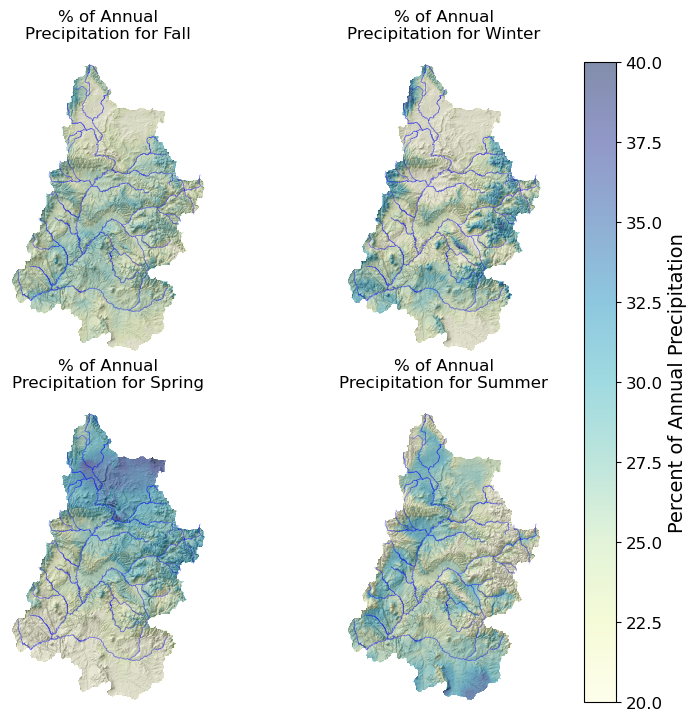

In [21]:
import matplotlib as mpl
# Create subplots for each season 12,3,6,9 and the annual (using ggplot) and plot the mean percent difference
labels = ['Fall','Winter', 'Spring', 'Summer', ]
fig, axs = plt.subplots(2,2, figsize=(12,8))
axs = axs.ravel()
for i, ds in enumerate([prism_normals_fall_annual_percent_ds,
                        prism_normals_winter_annual_percent_ds,
                        prism_normals_spring_annual_percent_ds,
                        prism_normals_summer_annual_percent_ds]):
    # im = ds.plot(ax=axs[i], cmap='YlGnBu', vmin=20, vmax=40, add_colorbar=False, alpha=0.5)
    axs[i].imshow(ls.hillshade(src.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray', extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
    ucrb_stream_traces.plot(ax=axs[i], color='blue', linewidth=0.5,  zorder=1, alpha=0.5)    
    im = axs[i].imshow(ds.values, alpha=0.5, cmap='YlGnBu', vmin=20, vmax=40, extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
    axs[i].set_title('% of Annual\nPrecipitation for {}'.format(labels[i]))
    axs[i].set_axis_off()
    # turn off the colorbar
    # set the colorbar label to be Percent Difference
    # cbar = axs[i].collections[0].colorbar
    # cbar.set_label('(%)')
    # plot the hcdn basins
    # ucrb_hcdn_basins.plot(ax=axs[i], facecolor="none", edgecolor="none", linewidth=0.5)
# create a colorbar for the entire ax5 with vmin=20 and vmax=40 and cmap='YlGnBu'
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.9, wspace=0, hspace=0.2)
cbar = fig.colorbar(im, ax=axs)
cbar.set_label('Percent of Annual Precipitation', size=14)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=12)

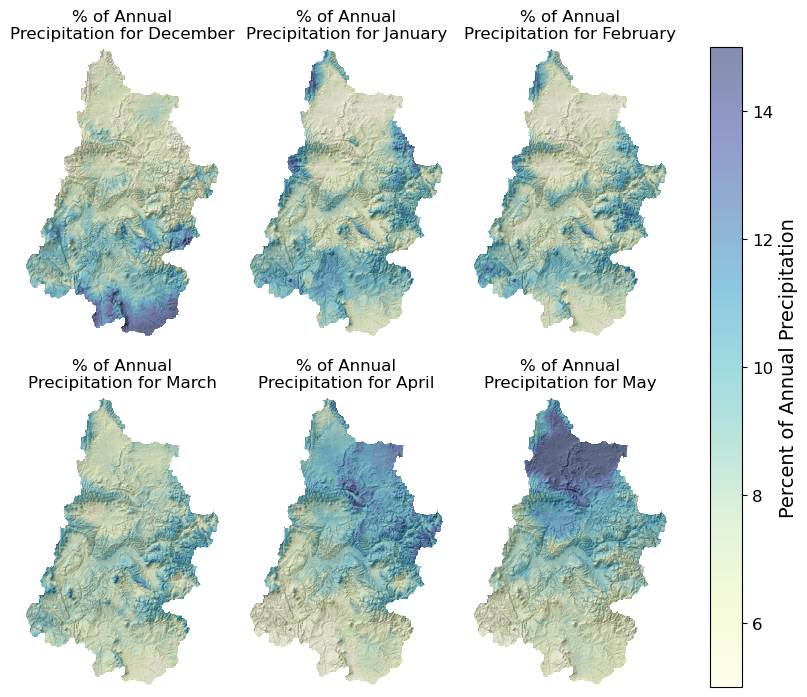

In [22]:
import matplotlib as mpl
# Create subplots for each season 12,3,6,9 and the annual (using ggplot) and plot the mean percent difference
labels = ['December', 'January', 'February', 'March', 'April', 'May']
fig, axs = plt.subplots(2,3, figsize=(12,8))
axs = axs.ravel()
for i, ds in enumerate([prism_normals_december_annual_percent_ds,
                        prism_normals_january_annual_percent_ds,
                        prism_normals_february_annual_percent_ds,
                        prism_normals_march_annual_percent_ds,
                        prism_normals_april_annual_percent_ds,
                        prism_normals_may_annual_percent_ds]):
    # im = ds.plot(ax=axs[i], cmap='YlGnBu', vmin=20, vmax=40, add_colorbar=False, alpha=0.5)
    axs[i].imshow(ls.hillshade(src.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray')
    im = axs[i].imshow(ds.values, alpha=0.5, cmap='YlGnBu', vmin=5, vmax=15)
    axs[i].set_title('% of Annual\nPrecipitation for {}'.format(labels[i]))
    axs[i].set_axis_off()
    # turn off the colorbar
    # set the colorbar label to be Percent Difference
    # cbar = axs[i].collections[0].colorbar
    # cbar.set_label('(%)')
    # plot the hcdn basins
    # ucrb_hcdn_basins.plot(ax=axs[i], facecolor="none", edgecolor="none", linewidth=0.5)
# create a colorbar for the entire ax5 with vmin=20 and vmax=40 and cmap='YlGnBu'
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.9, wspace=0, hspace=0.2)
cbar = fig.colorbar(im, ax=axs)
cbar.set_label('Percent of Annual Precipitation', size=14)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=12)

Text(0.5, 1.0, 'Annual Precipitation')

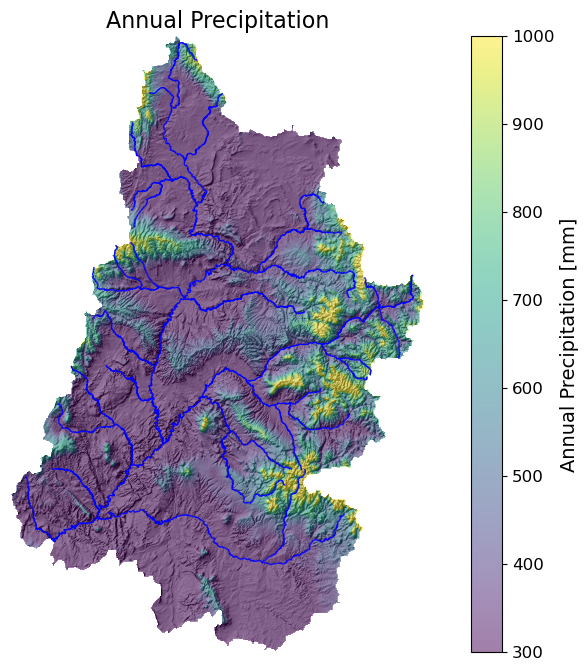

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
# add another plot for the annual mean
ax.imshow(ls.hillshade(src.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
im = ax.imshow(prism_normals_annual_ds.values, alpha=0.5, cmap='viridis', vmin=300, vmax=1000,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=1,  zorder=1, alpha=1) 
# set the colorbar label to be Percent Difference
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Annual Precipitation [mm]', size=14)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=12)
# plot the hcdn basins
# ucrb_hcdn_basins.plot(ax=ax, facecolor="none", edgecolor="none", linewidth=0.5)
ax.set_axis_off()
# add title to axs[4]
ax.set_title('Annual Precipitation', size=16)

In [24]:
src_4km = rioxr.open_rasterio('../basin_characteristics/ucrb_dem_32613_150m.tif')
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)
# downsample to 800m
src_4km = src_4km.rio.reproject(dst_crs='EPSG:32613', resolution=3945.843241747955)
# mask values less than 0
src_4km = src_4km.where(src_4km > 0)

dx, dy =3945.843241747955,3945.843241747955

In [25]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')
# these two basins are especially difficult since they are small and extremely flashy and ephemeral. the last basin ended its record in the early 2000s
bad_gages = hcdn_basins.index.isin(['09306242','09378170','09378630']) 
hcdn_basins = hcdn_basins[~bad_gages]
hcdn_basins = hcdn_basins.set_crs(epsg='32613', allow_override=True)

In [26]:
annual_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/annual_significant_change.csv', index_col=0)
annual_no_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/annual_no_significant_change.csv', index_col=0)
# do the same for the seasonal changes
spring_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/spring_significant_change.csv', index_col=0)
spring_no_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/spring_no_significant_change.csv', index_col=0)
summer_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/summer_significant_change.csv', index_col=0)
summer_no_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/summer_no_significant_change.csv', index_col=0)
fall_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/fall_significant_change.csv', index_col=0)
fall_no_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/fall_no_significant_change.csv', index_col=0)
winter_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/winter_significant_change.csv', index_col=0)
winter_no_significant_change = pd.read_csv('../data/precipdata/station_changes_by_season/winter_no_significant_change.csv', index_col=0)

# read station locations
station_locations = gpd.read_file('../data/geodata/prcp_stations.json')


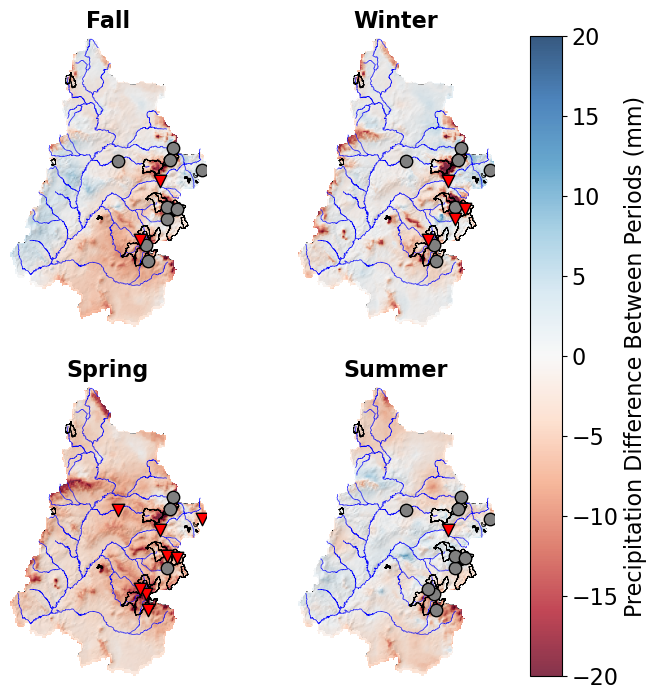

In [36]:
# Create subplots for each season 12,3,6,9 and the annual (using ggplot) and plot the mean percent difference
labels = ['Fall','Winter', 'Spring', 'Summer']
fig, axs = plt.subplots(2,2, figsize=(12,8))
axs = axs.ravel()
month_station_dict = {10:[fall_significant_change,fall_no_significant_change],
                      1:[winter_significant_change,winter_no_significant_change],
                      4:[spring_significant_change,spring_no_significant_change],
                      7:[summer_significant_change,summer_no_significant_change],
                      }

for i, month in enumerate([10,1,4,7]):
    
    axs[i].imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                                                            ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                                                            ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                                                            ucrb_basin_boundary.bounds.loc[0]['maxy']])
    ucrb_stream_traces.plot(ax=axs[i], color='blue', linewidth=0.5, label='UCRB Streams', zorder=1)                                                                                                            
    im = axs[i].imshow(mean_percent_diff(prism_4km_pre_seasonal_ds_ma, prism_4km_post_seasonal_ds_ma, month)['ppt'].values,
                       cmap='RdBu',alpha=0.8, vmin=-20, vmax=20,extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
    # axs[i].set_title('Difference Between\nPeriod Means for {}'.format(labels[i]))
    axs[i].set_title('{}'.format(labels[i]), size=16, fontweight='bold')
    axs[i].set_axis_off()
    # set the colorbar label to be Percent Difference
    # cbar = axs[i].collections[0].colorbar
    # cbar.set_label('Seasonal Precipitation\n Difference (mm)')
    # plot the hcdn basins
    # ax2 = axs[i].twinx()
    hcdn_basins.plot(ax=axs[i], facecolor="none", edgecolor="black", linewidth=0.5, label='HCDN Basins')

    station_locations[station_locations['STATION'].isin(month_station_dict[month][1].index)].plot(ax=axs[i], color='gray', markersize=80, legend=False, ec='k',
                                                                                                    label='Insignificant Decrease or Increase')
# plot station locations included in annual_significant_change with a downward red triangle
    station_locations[station_locations['STATION'].isin(month_station_dict[month][0].index)].plot(ax=axs[i], color='red', markersize=80, marker='v', legend=False,
                                                                                                  label='Significant Decrease (p<0.05)',
                                                                                                  ec='black')
    axs[i].set_xlim([ucrb_basin_boundary.bounds.loc[0]['minx'], ucrb_basin_boundary.bounds.loc[0]['maxx']])
    axs[i].set_ylim([ucrb_basin_boundary.bounds.loc[0]['miny'], ucrb_basin_boundary.bounds.loc[0]['maxy']])
    # # plot ucrb boundary
    # ucrb_basin_boundary.plot(ax=axs[i], facecolor="none", edgecolor="black", linewidth=2)
    # # turn off axis
    # ax2.axis('off')
    # # make the ax2 background transparent
    # ax2.patch.set_alpha(0)
    # if axs[i] == axs[2]:
        # axs[i].legend(loc='upper left', bbox_to_anchor=(0.45, -0.2), fontsize=12)
# create a colorbar for the entire ax5 with vmin=20 and vmax=40 and cmap='YlGnBu'
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0, hspace=0.2)
cbar = fig.colorbar(im, ax=axs)
cbar.set_label('Precipitation Difference Between Periods (mm)', size=16)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=16)
# save figure at 700 dpi and 9x6 centimeters
fig.savefig('../figures/seasonal_precipitation_difference.png', dpi=700, pad_inches=0.1)

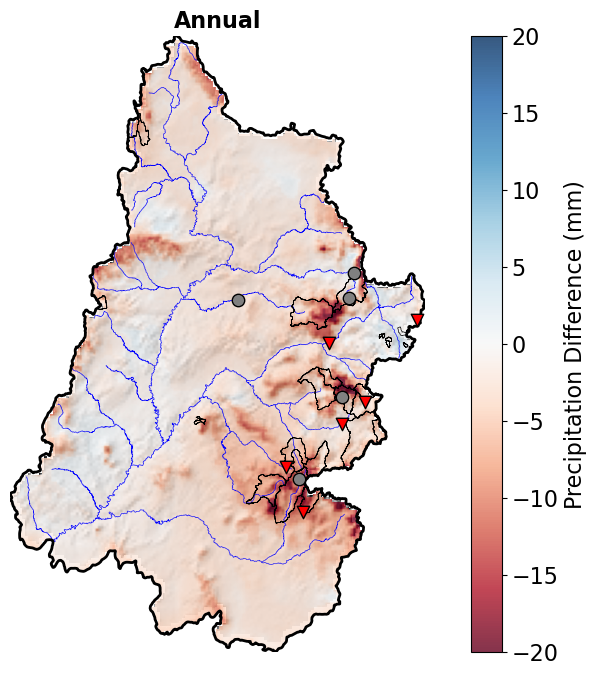

In [37]:
# add another plot for the annual mean
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(ls.hillshade(src_4km.squeeze().values, vert_exag=10, dx=dx, dy=dy), cmap='gray',extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])
ucrb_stream_traces.plot(ax=ax, color='blue', linewidth=0.5, label='UCRB Streams', zorder=1)    
im = ax.imshow(mean_percent_diff(prism_4km_pre_annual_ds_ma, prism_4km_post_annual_ds_ma, None)['ppt'].values, alpha=0.8, cmap='RdBu', vmin=-20, vmax=20,
                                                                        extent=[ucrb_basin_boundary.bounds.loc[0]['minx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxx'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['miny'], 
                                                                        ucrb_basin_boundary.bounds.loc[0]['maxy']])

hcdn_basins.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, label='HCDN Basins')
# plot ucrb boundary
ucrb_basin_boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)

station_locations[station_locations['STATION'].isin(annual_no_significant_change.index)].plot(ax=ax, color='gray', markersize=80, legend=False, ec='k',
                                                                                                )
# plot station locations included in annual_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(annual_significant_change.index)].plot(ax=ax, color='red', markersize=80, marker='v', legend=False,
                                                                                                ec='black')
# set the colorbar label to be Percent Difference
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Precipitation Difference (mm)', size=16)
# increase the size of the tick labels for the colorbar
cbar.ax.tick_params(labelsize=16)

# plot the hcdn basins
# ucrb_hcdn_basins.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
ax.set_axis_off()
# add title to ax
ax.set_title('Annual', fontsize=16, fontweight='bold')
# save figure at 700 dpi and 9x6 centimeters
fig.savefig('../figures/annual_precipitation_difference.png', dpi=700, pad_inches=0.1)

### Open DEM and get elevations for each basin

In [30]:
ucrb_dem = rioxr.open_rasterio('../basin_characteristics/ucrb_dem_150m.tif')

In [31]:
basin_mean_elevations = {}
for gage in ucrb_hcdn_basins.gage:
    basin = ucrb_hcdn_basins[ucrb_hcdn_basins.gage==gage]
    clipped_dem = ucrb_dem.rio.clip(basin.geometry).squeeze()
    clipped_dem_ma = clipped_dem.where(clipped_dem>0)
    basin_mean_elevations[gage] = clipped_dem_ma.mean().values

# Hyposmetric Plots

In [212]:
ucrb_dem = rioxr.open_rasterio('../basin_characteristics/ucrb_dem_150m.tif')

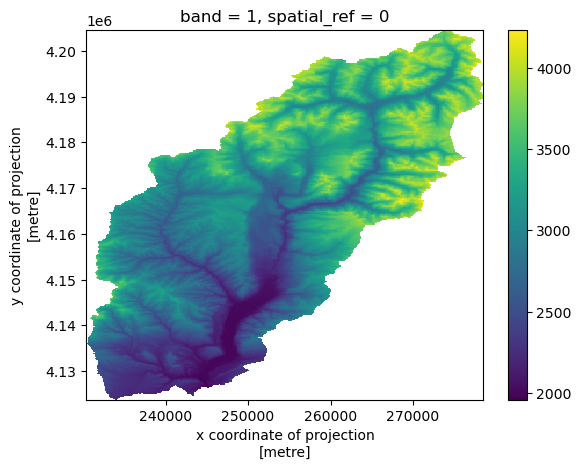

In [213]:
basin = ucrb_hcdn_basins[ucrb_hcdn_basins.gage=='09361500']
clipped_dem = ucrb_dem.rio.clip(basin.geometry).squeeze()
clipped_dem_ma = clipped_dem.where(clipped_dem>0)
clipped_dem_ma.plot()

In [214]:
sorted_dropped_elevations = np.sort(np.ma.compressed(clipped_dem_ma))
sorted_dropped_nan_elevations = sorted_dropped_elevations[~np.isnan(sorted_dropped_elevations)]

sorted_dropped_areas = np.ma.compressed(area_array).cumsum()
sorted_dropped_nan_areas = sorted_dropped_areas[~np.isnan(sorted_dropped_elevations)]

NameError: name 'area_array' is not defined

In [304]:
sorted_dropped_nan_areas

array([1.97665765e-02, 3.95331530e-02, 5.92997295e-02, ...,
       2.00322393e+03, 2.00324370e+03, 2.00326346e+03])

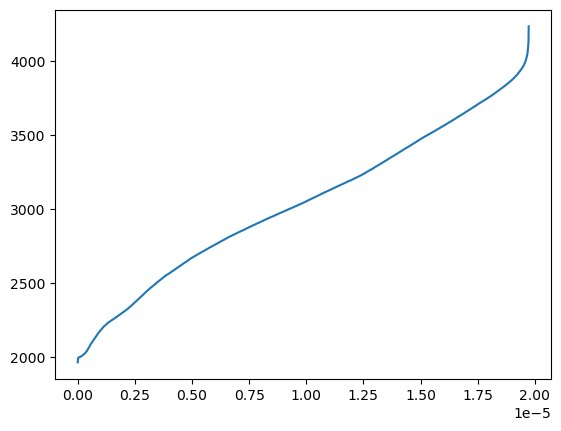

In [301]:
plt.plot(sorted_dropped_nan_areas/sorted_dropped_nan_areas.sum(),sorted_dropped_nan_elevations)

In [197]:
ydim = clipped_dem_ma.rio.transform()[0]
dx = ydim/1000
dy = ydim/1000
# Used to calculate the area of each pixel.
if ydim < 0:
    yres = ydim * -1.0
# array with indices
rows, cols = np.indices(clipped_dem_ma.shape) 
nrows = clipped_dem_ma.shape[0]
ncols = clipped_dem_ma.shape[1]

# new array for area values
area_array = np.empty(clipped_dem_ma.shape)

# nested loop to create array with area values
for row in range(nrows):
    for col in range(ncols):
        area_array[row,col] = dx * dy

In [188]:
# elevation 5M
clip_ma = np.ma.masked_where(clipped_dem_ma.isnull(), clipped_dem_ma)
clip_min = clipped_dem_ma.min()
clip_max = clipped_dem_ma.max()

# height of point/contour above base of basin
clip_array_comp = np.ma.compressed(clip_ma)
h_clip = clipped_dem_ma - clip_min

# total height of basin
H_clip = clip_max - clip_min

# normalize elev for hypsometric curve
elevNorm_clip = h_clip / H_clip


Make a masked array of cell area and calculate Area values used in hypsometric analysis

In [219]:
# cell area 5M
area_clip = area_array
# total area of basin/area
area_clip_sum = np.sum(area_clip)
# cumulative area for hypsographyc curve
area_clip_csum = np.cumsum(np.ma.compressed(area_clip))
# normalized area for hypsometric curve
area_norm_clip = area_clip / area_clip_sum
area_norm_csum = np.cumsum(np.ma.compressed(area_norm_clip))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


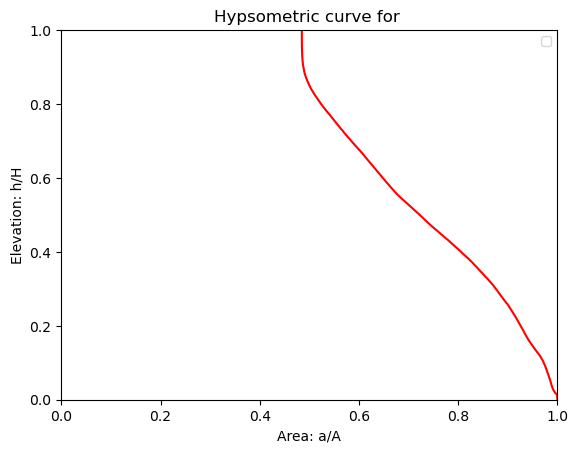

In [220]:
# 5M
plt.plot(area_norm_csum[::-1], np.sort(np.ma.compressed(elevNorm_clip)), c='r')

# decorations
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.ylabel('Elevation: h/H')
plt.xlabel('Area: a/A')
plt.title('Hypsometric curve for ')
lg = plt.legend(loc='upper right', fontsize=9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


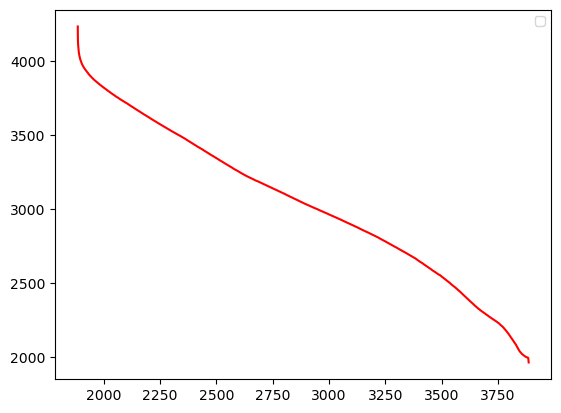

In [221]:
# 5M
plt.plot(area_clip_csum[::-1], np.sort(np.ma.compressed(clipped_dem_ma)), c='r')

# plt.ylim(0.0, 5000.0)
lg = plt.legend(loc='upper right', fontsize=9)

In [154]:
# auxiliar functions
def roundBase(x, base=5):
    return int(base * round(float(x)/base))

def roundUp(x, base=50):
    return int(base * np.ceil(float(x)/base))

def roundDown(x, base=50):
    return int(base * np.floor(float(x)/base))


In [249]:
# ii) calculating area per elevation
from scipy import ndimage
# define bins for all histograms
binsize = 500

clip_range = np.arange(0, int(clip_max)+1)

sum_area_clip = ndimage.sum(area_array, clipped_dem_ma, clip_range)

# sum the values of areas in each bin
bins_sum = []
for i in bincenters:
    low = i - (binsize / 2)
    up = i + (binsize / 2)
    b_sum = np.sum(sum_area_clip[int(low):int(up)])
    bins_sum.append(b_sum)
    